<a href="https://colab.research.google.com/github/mohini-pasi/Fake-News-Detection/blob/main/fake-realnews-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Models to try
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Set style for plots
plt.style.use('seaborn-v0_8')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load and explore the data
# Assuming the data is in a CSV file named 'news_data.csv'
df = pd.read_csv(r'news.csv')

# Display basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nLabel Distribution:")
print(df['label'].value_counts())

Dataset Shape: (6335, 4)

First few rows:
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      -----

In [ ]:
# Data Preprocessing
# Drop unnecessary columns
df = df.drop(['Unnamed: 0'], axis=1, errors='ignore')

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Handle missing values if any
df = df.dropna()

# Combine title and text for better feature extraction
df['content'] = df['title'] + ' ' + df['text']

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print("\nLabel mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Missing values:
title    0
text     0
label    0
dtype: int64

Label mapping: {'FAKE': np.int64(0), 'REAL': np.int64(1)}


In [ ]:
# Text Preprocessing Function
def preprocess_text(text):
    if isinstance(text, float):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# Apply preprocessing
print("Preprocessing text data...")
df['cleaned_content'] = df['content'].apply(preprocess_text)
print("Text preprocessing completed!")

Preprocessing text data...
Text preprocessing completed!


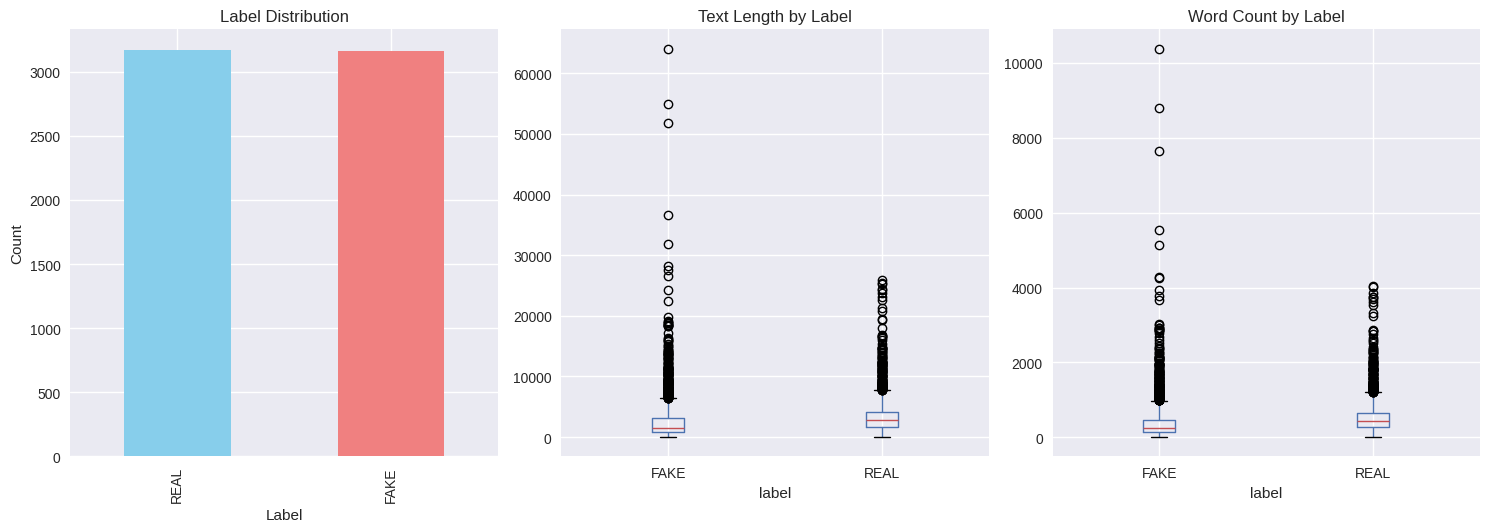


Text Length Statistics:
        count         mean          std   min      25%     50%     75%  \
label                                                                    
FAKE   3164.0  2498.447535  3284.954760   9.0   820.75  1568.5  3079.0   
REAL   3171.0  3210.455377  2593.162173  50.0  1684.50  2822.0  4127.0   

           max  
label           
FAKE   64040.0  
REAL   25959.0  


In [ ]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# 1. Label distribution
plt.subplot(2, 3, 1)
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# 2. Text length analysis
plt.subplot(2, 3, 2)
df['text_length'] = df['cleaned_content'].apply(len)
df.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Text Length by Label')
plt.suptitle('')

# 3. Word count analysis
plt.subplot(2, 3, 3)
df['word_count'] = df['cleaned_content'].apply(lambda x: len(x.split()))
df.boxplot(column='word_count', by='label', ax=plt.gca())
plt.title('Word Count by Label')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Display basic statistics
print("\nText Length Statistics:")
print(df.groupby('label')['text_length'].describe())

In [ ]:
# Prepare features and target
X = df['cleaned_content']
y = df['label_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 5068
Test set size: 1267


In [11]:
# Initialize vectorizers
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.8
)

count_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.8
)

# Models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Evaluate models with different vectorizers
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Try with TF-IDF
    pipeline_tfidf = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('model', model)
    ])

    # Try with Count Vectorizer
    pipeline_count = Pipeline([
        ('count', count_vectorizer),
        ('model', model)
    ])

    # Cross-validation with TF-IDF
    cv_scores_tfidf = cross_val_score(pipeline_tfidf, X_train, y_train, cv=5, scoring='accuracy')

    # Cross-validation with Count Vectorizer
    cv_scores_count = cross_val_score(pipeline_count, X_train, y_train, cv=5, scoring='accuracy')

    results[model_name] = {
        'TF-IDF Mean CV Score': cv_scores_tfidf.mean(),
        'TF-IDF Std CV Score': cv_scores_tfidf.std(),
        'Count Vectorizer Mean CV Score': cv_scores_count.mean(),
        'Count Vectorizer Std CV Score': cv_scores_count.std()
    }

    print(f"{model_name} - TF-IDF CV Accuracy: {cv_scores_tfidf.mean():.4f} (+/- {cv_scores_tfidf.std() * 2:.4f})")
    print(f"{model_name} - Count Vectorizer CV Accuracy: {cv_scores_count.mean():.4f} (+/- {cv_scores_count.std() * 2:.4f})")


Training Logistic Regression...
Logistic Regression - TF-IDF CV Accuracy: 0.9118 (+/- 0.0080)
Logistic Regression - Count Vectorizer CV Accuracy: 0.9084 (+/- 0.0090)

Training Multinomial NB...
Multinomial NB - TF-IDF CV Accuracy: 0.8735 (+/- 0.0098)
Multinomial NB - Count Vectorizer CV Accuracy: 0.8694 (+/- 0.0140)

Training Random Forest...
Random Forest - TF-IDF CV Accuracy: 0.9021 (+/- 0.0155)
Random Forest - Count Vectorizer CV Accuracy: 0.8982 (+/- 0.0106)

Training SVM...
SVM - TF-IDF CV Accuracy: 0.9270 (+/- 0.0126)
SVM - Count Vectorizer CV Accuracy: 0.8747 (+/- 0.0100)

Training Decision Tree...
Decision Tree - TF-IDF CV Accuracy: 0.8045 (+/- 0.0293)
Decision Tree - Count Vectorizer CV Accuracy: 0.8120 (+/- 0.0178)

Training XGBoost...
XGBoost - TF-IDF CV Accuracy: 0.9159 (+/- 0.0171)
XGBoost - Count Vectorizer CV Accuracy: 0.9146 (+/- 0.0111)


In [13]:
# Display results comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison Results:")
print(results_df.sort_values('TF-IDF Mean CV Score', ascending=False))


Model Comparison Results:
                     TF-IDF Mean CV Score  TF-IDF Std CV Score  \
SVM                              0.926992             0.006281   
XGBoost                          0.915940             0.008569   
Logistic Regression              0.911799             0.003981   
Random Forest                    0.902128             0.007767   
Multinomial NB                   0.873520             0.004922   
Decision Tree                    0.804456             0.014656   

                     Count Vectorizer Mean CV Score  \
SVM                                        0.874705   
XGBoost                                    0.914560   
Logistic Regression                        0.908444   
Random Forest                              0.898182   
Multinomial NB                             0.869378   
Decision Tree                              0.811956   

                     Count Vectorizer Std CV Score  
SVM                                       0.004999  
XGBoost           

In [14]:
# Train the best performing model
print("\nTraining the best model...")

# Based on results, let's use Logistic Regression with TF-IDF
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=2,
        max_df=0.8
    )),
    ('model', LogisticRegression(random_state=42, max_iter=1000, C=1.0))
])

# Fit the model
best_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Training the best model...

Test Accuracy: 0.9155

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.90      0.94      0.92       633
        REAL       0.93      0.90      0.91       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



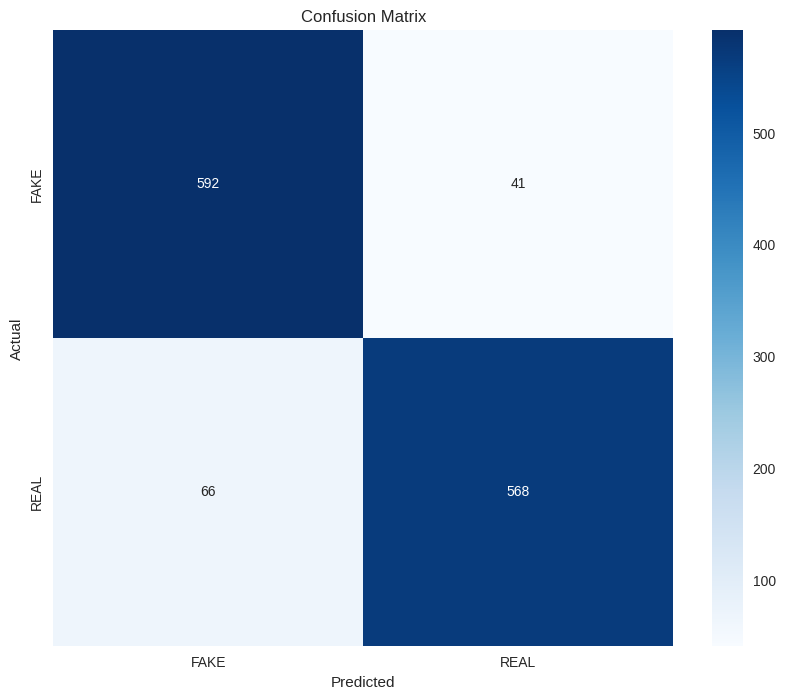

In [15]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
# Feature Importance Analysis (for Logistic Regression)
if hasattr(best_pipeline.named_steps['model'], 'coef_'):
    feature_names = best_pipeline.named_steps['tfidf'].get_feature_names_out()
    coefficients = best_pipeline.named_steps['model'].coef_[0]

    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    })

    # Top features for FAKE news
    print("\nTop 20 features for FAKE news prediction:")
    print(feature_importance.nlargest(20, 'importance'))

    # Top features for REAL news
    print("\nTop 20 features for REAL news prediction:")
    print(feature_importance.nsmallest(20, 'importance'))


Top 20 features for FAKE news prediction:
          feature  importance
3807         said    6.403125
3870          say    2.975620
3645   republican    2.849166
1852          gop    2.738787
885       conserv    2.629164
1008         cruz    2.572534
581        candid    2.513346
1068        debat    2.453564
3850       sander    2.201591
2255         iran    2.112118
3341       presid    2.082603
4194        state    2.071250
3171      percent    1.957866
271        attack    1.932820
2621      marriag    1.918624
2270  islam state    1.911974
4391          tax    1.882821
2318          job    1.865134
1743     fox news    1.841059
3274        polit    1.763350

Top 20 features for REAL news prediction:
              feature  importance
2980            octob   -4.456500
2016          hillari   -3.598514
2940           novemb   -2.682064
3981            share   -2.558723
1365            elect   -2.518059
237            articl   -2.482754
4114            sourc   -2.464281
4818        

In [ ]:
# Hyperparameter Tuning
print("\nPerforming hyperparameter tuning...")

param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Final evaluation
y_pred_final = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

In [ ]:
# Model Interpretation and Prediction Function
def predict_news(title, text, model=best_model, label_encoder=label_encoder):
    """
    Predict whether a news article is REAL or FAKE
    """
    content = title + ' ' + text
    cleaned_content = preprocess_text(content)

    prediction = model.predict([cleaned_content])
    probability = model.predict_proba([cleaned_content])

    predicted_label = label_encoder.inverse_transform(prediction)[0]
    confidence = probability[0][prediction[0]]

    return {
        'prediction': predicted_label,
        'confidence': confidence,
        'probabilities': {
            'REAL': probability[0][0],
            'FAKE': probability[0][1]
        }
    }

# Test the prediction function with examples
test_cases = [
    {
        'title': "Breaking News: Major Scientific Discovery",
        'text': "Scientists have made a groundbreaking discovery that could change the world."
    },
    {
        'title': "Aliens Land in New York",
        'text': "Extraterrestrial beings have been spotted in Central Park today."
    }
]

print("\nTesting Prediction Function:")
for i, test_case in enumerate(test_cases, 1):
    result = predict_news(test_case['title'], test_case['text'])
    print(f"\nTest Case {i}:")
    print(f"Title: {test_case['title']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: {result['probabilities']}")

In [ ]:
# Save the model
import joblib

model_assets = {
    'model': best_model,
    'label_encoder': label_encoder,
    'vectorizer': best_pipeline.named_steps['tfidf']
}

joblib.dump(model_assets, 'fmodel/ake_news_classifier.pkl')
print("Model saved successfully!")

# To load the model later:
# loaded_assets = joblib.load('fake_news_classifier.pkl')
# loaded_model = loaded_assets['model']
# loaded_label_encoder = loaded_assets['label_encoder']

In [ ]:
# Performance Summary
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Best Model: {type(best_model.named_steps['model']).__name__}")
print(f"Best Vectorizer: TF-IDF")

# Feature importance summary
if hasattr(best_model.named_steps['model'], 'coef_'):
    feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
    coefficients = best_model.named_steps['model'].coef_[0]

    top_fake_features = sorted(zip(feature_names, coefficients),
                              key=lambda x: x[1], reverse=True)[:10]
    top_real_features = sorted(zip(feature_names, coefficients),
                              key=lambda x: x[1])[:10]

    print("\nTop indicators for FAKE news:")
    for feature, coef in top_fake_features:
        print(f"  {feature}: {coef:.4f}")

    print("\nTop indicators for REAL news:")
    for feature, coef in top_real_features:
        print(f"  {feature}: {coef:.4f}")

In [ ]:
# 1️⃣ Sample News (You can enter any real or fake news text here)
sample_news = """
Scientists have discovered a new species of frog in the Amazon rainforest.
The frog is bright blue and only 2 cm long. This could be a major breakthrough
for biodiversity and environmental research.
"""

# 2️⃣ Text Cleaning (Use the SAME function you used during training)
cleaned_text = wordopt(sample_news)     # ← If your cleaning function has a different name, use that one

# 3️⃣ Vectorization (Use the SAME vectorizer that was used during training)
input_data = vectorizer.transform([cleaned_text])

# 4️⃣ Predict
prediction = model.predict(input_data)[0]          # Model name must be the same as in training
probability = model.predict_proba(input_data)[0]

# 5️⃣ Output Results
print("🔍 NEWS INPUT:\n", sample_news)
print("\n🧪 MODEL PREDICTION:", "REAL" if prediction == 1 else "FAKE")
print("\n📊 Confidence:")
print("   Fake  →", probability[0])
print("   Real  →", probability[1])
